In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Conv2D,Dense,GlobalMaxPooling2D,MaxPooling2D,BatchNormalization,Add
from tensorflow.keras.models import Sequential

In [2]:
training="E:/Projects/solar panel detection/dataset/training/"
label="E:/Projects/solar panel detection/dataset/labels_training.csv"

In [3]:
df=pd.read_csv(label)

In [4]:
df.head()

,id,label
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1


In [5]:
# LOADING DATA AND PREPROCESSING

def load_data(dir_data, dir_labels):
    '''
    dir_data: Data directory
    dir_labels: Respective csv file containing ids and labels
    returns: Array of all the image arrays and its respective labels
    '''
    labels_pd = pd.read_csv(dir_labels)                         # Read the csv file with labels and ids as we saw above
    ids = labels_pd.id.values                                   # Extracting ids from the csv file
    data = []                                                   # Initiating the empty list to store each image as numpy array
    for identifier in ids:                                      # Looping into the desired folder
        fname = dir_data + identifier.astype(str) + '.jpg'      # Generating the file name
        image = mpl.image.imread(fname)                         # Reading image as numpy array using matplotlib
        data.append(image)                                      # Appending this array into the empty list and repeat the above cycle
    data = np.array(data)                                       # Now, convert the data list into data array
    labels = labels_pd.label.values                             # Extract labels from the csv file
    return data, labels                                         # Return the array of data and respective labels

In [6]:
X, y = load_data(training,label)

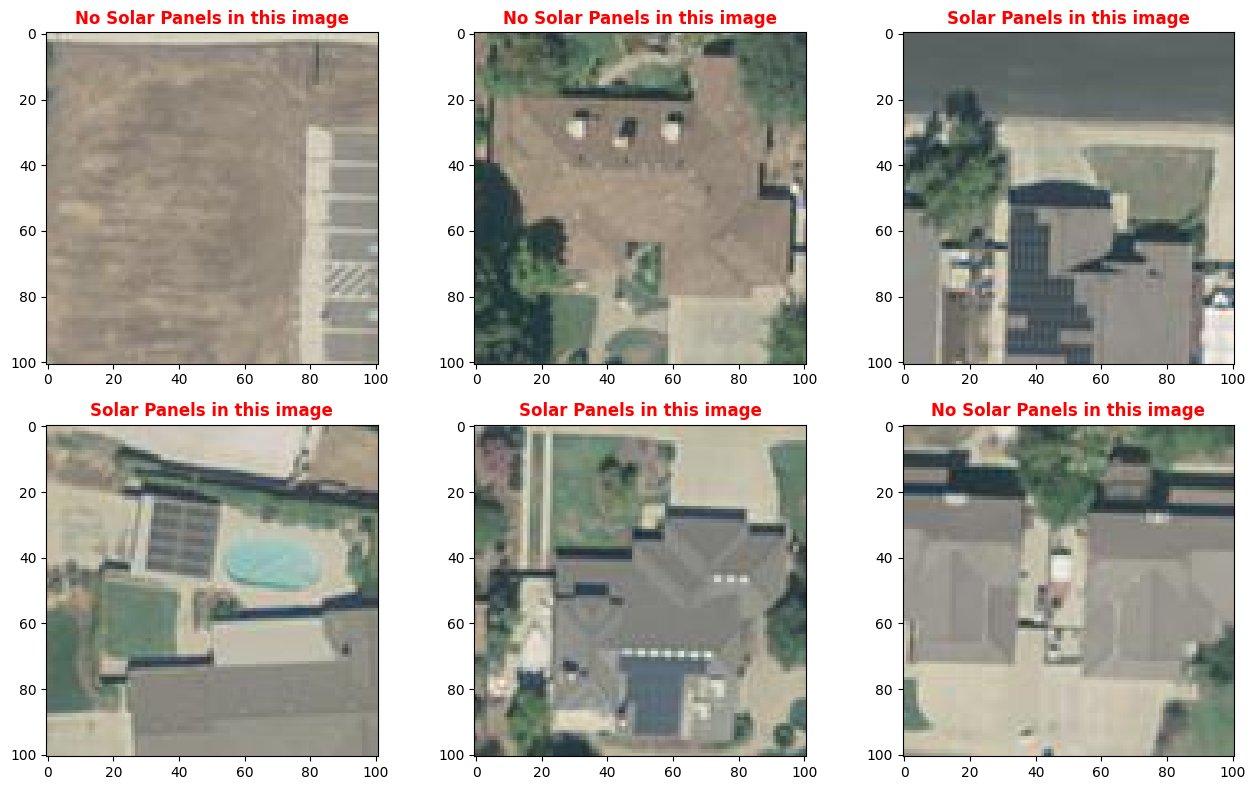

In [7]:
plt.figure(figsize = (13,8))                         # Adjust the figure size
for i in range(6):                                   # For first 6 images in the data
  plt.subplot(2, 3, i+1)                             # Create subplots
  plt.imshow(X[i])                                   # Show the respective image in respective postion
  if y[i] == 0:                                      # If label is 0
    title = 'No Solar Panels in this image'          # Set this as the title
  else:                                              # Else label is 1
    title = 'Solar Panels in this image'             # Set this as the title
  plt.title(title, color = 'r', weight = 'bold')     # Adding title to each images in the subplot
plt.tight_layout()                                   # Automatically adjusts the width and height between images in subplot
plt.show() 

In [8]:
print('X shape:\n', X.shape)
print('Distribution of y', np.bincount(y))
X = X / 255.0

X shape:
 (1500, 101, 101, 3)
Distribution of y [995 505]


In [9]:
def build_model():
    '''
    Returns a Keras CNN model
    '''

    # define image dimensions
    IMAGE_HEIGHT = 101
    IMAGE_WIDTH = 101
    IMAGE_CHANNELS = 3

    # define a straightforward sequential neural network
    model = Sequential()

    # layer-1
    #filter is convolutional matrix which is applied across the image = 32 filters
    #kernal size is 3x3 matrix(filter)
    #relu positive kept as it is, negative is taken out
    model.add(Conv2D(filters=32,
                     kernel_size=3,
                     activation='relu',
                     input_shape=(IMAGE_HEIGHT,
                                  IMAGE_WIDTH,
                                  IMAGE_CHANNELS)))

    #adding normalizing layer to improve the speed of training
    model.add(BatchNormalization())

    # As we move forword in the layers pattern gets more complex,
    # to capture the maximum combinations in subsequent layers
    # layer-2
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # layer-3
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # Pooling layer is to reduce dimentions of feature map by summerizing presence of features
    # max-pool - sends only imp data to next layer - here 2x2 matrix
    model.add(MaxPooling2D(pool_size=2))

    # layer-4
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # layer-5
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # max-pool
    model.add(MaxPooling2D(pool_size=2))

    # layer-6
    model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling2D())

    # output layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [10]:
def cv_performance_assessment(X, y, num_folds, clf, random_seed=1):
    '''
    Cross validated performance assessment

    Input:
        X: training data
        y: training labels
        num_folds: number of folds for cross validation
        clf: classifier to use

    Divide the training data into k folds of training and validation data.
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are
    aggregated and output.
    '''

    prediction_scores = np.empty(y.shape[0], dtype='object')

    # establish the num_folds folds
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

    for train_index, val_index in kf.split(X, y):
        # extract the training and validation data for this fold
        X_train, X_val = X[train_index], X[val_index]
        y_train = y[train_index]

        # give more weight to minority class based on the target class distribution
        class_weight = {0: 505/1500, 1: 995/1500}

        # train the classifier
        training = clf.fit(x=X_train,
                           y=y_train,
                           class_weight=class_weight,
                           batch_size=32,
                           epochs=10,
                           shuffle=True,
                           verbose=1)

        # test the classifier on the validation data for this fold
        y_val_pred_probs = clf.predict(X_val).reshape((-1, ))

        # save the predictions for this fold
        prediction_scores[val_index] = y_val_pred_probs

    return prediction_scores

In [11]:
num_folds = 3

random_seed = 1

cnn = build_model()

cnn.summary()

cnn_y_hat_prob = cv_performance_assessment(X, y, num_folds, cnn, random_seed=random_seed)

c:\Users\Sujan2004\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 99, 99, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 99, 99, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 97, 97, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 95, 95, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 95, 95, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 43, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 43, 43, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 19, 19, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 19, 19, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,105 (1.49 MB)

 Trainable params: 389,889 (1.49 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5416 - loss: 0.3920
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 986ms/step - accuracy: 0.7738 - loss: 0.2257
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 998ms/step - accuracy: 0.8717 - loss: 0.1344
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 986ms/step - accuracy: 0.9117 - loss: 0.1086
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 933ms/step - accuracy: 0.8852 - loss: 0.1222
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 930ms/step - accuracy: 0.9529 - loss: 0.0648
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 978ms/step - accuracy: 0.9835 - loss: 0.0357
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9881 - loss: 0.0252
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9923 - loss: 0.0268
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9560 - loss: 0.0601
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 679ms/step
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9379 - loss: 0.0727
Epoch 2/10
32/3

In [13]:
# Check the column names
print(df.columns)

# Ensure 'predicted_score' column exists
if 'predicted_score' not in df.columns:
    # Create the 'predicted_score' column if it doesn't exist
    df['predicted_score'] = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]

# Now you can safely access the 'predicted_score' column
fn = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 0)]['id'])  # False Negative
fp = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 1)]['id'])  # False Positive      # False Positive
tp = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 1)]['id'])      # True Positive
tn = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 0)]['id']) 

Index(['id', 'label', 'predicted_class'], dtype='object')


In [14]:
def show_images(image_ids, num_images, title, color):
    
    rcParams['figure.figsize'] = 20, 4                                          # Adjusting figure size
    plt.figure()                                                                # Generating figure
    n = 1                                                                       # index where plot should apear in subplot
    for i in image_ids[0:num_images]:                                           # Run a loop for total number of images to display
        plt.subplot(1, num_images, n)                                           # Generate a subplot
        plt.imshow(X[i, :, :, :])                                               # Display the image
        plt.title('Image id: ' + str(i))                                        # Add title
        plt.axis('off')                                                         # Turn off the axis
        n+=1                                                                    # Incrememting index by 1
    plt.suptitle('\n'+title, fontsize=15, color = color, weight = 'bold')       # Adding main title to subplot
    plt.show()   

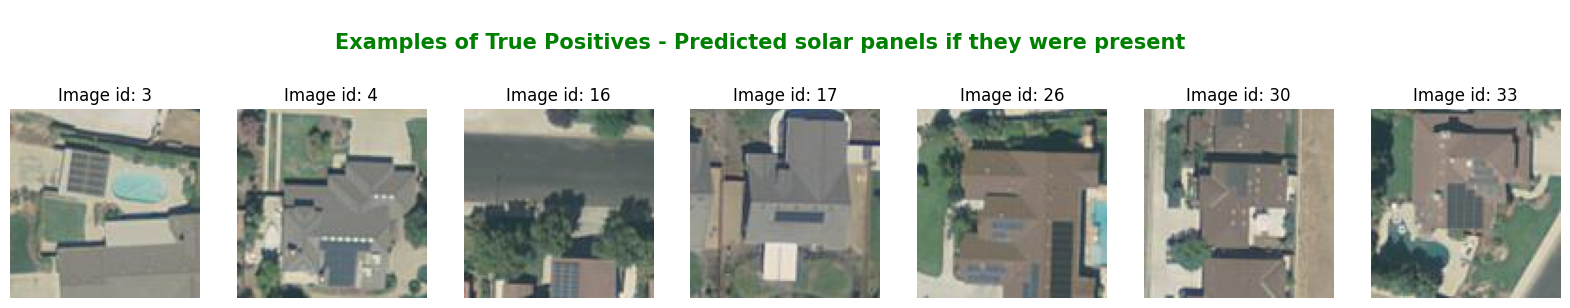

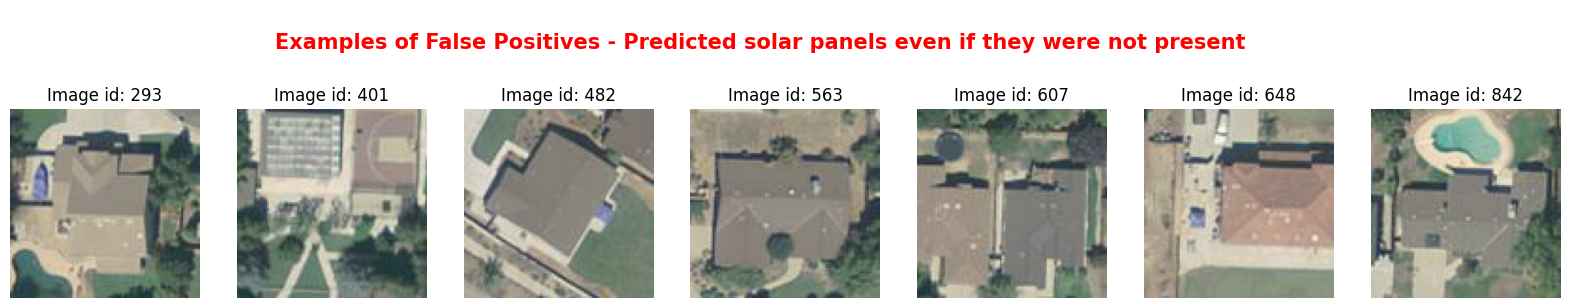

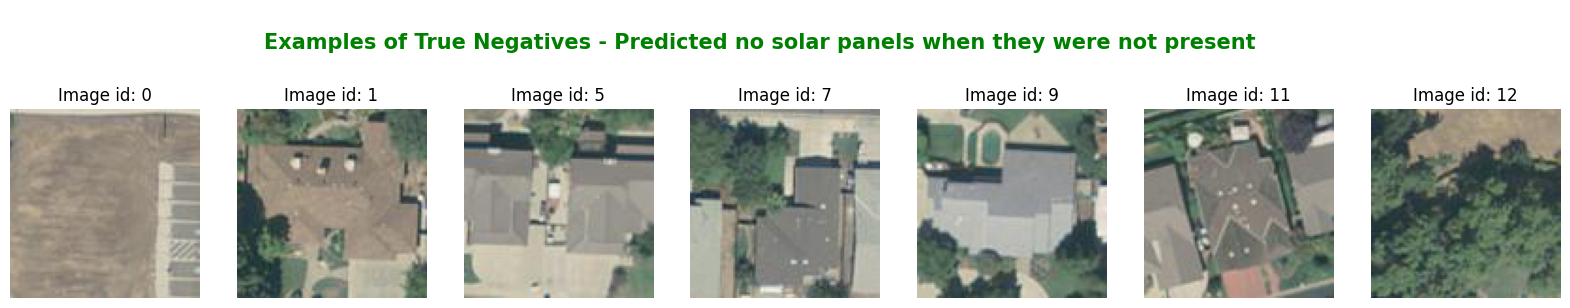

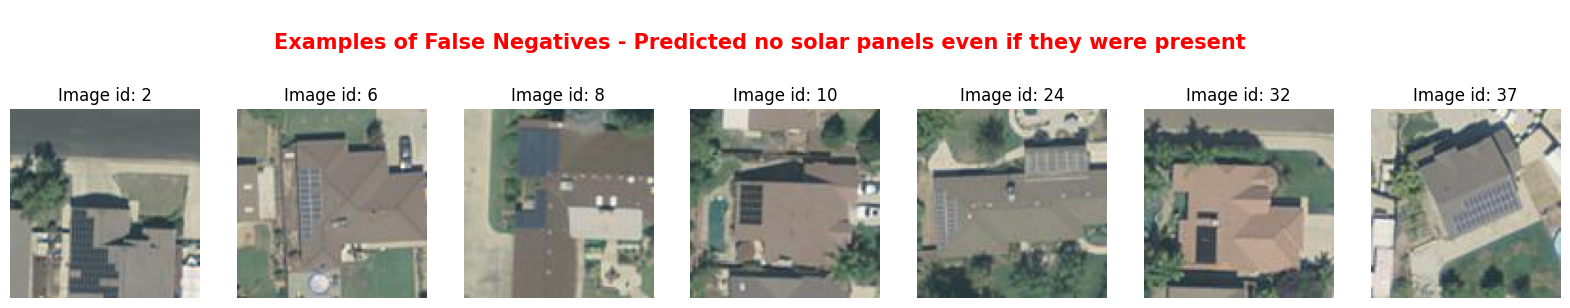

In [15]:
num_images = 7  # number of images to look at
show_images(tp, num_images, 'Examples of True Positives - Predicted solar panels if they were present', 'g')
show_images(fp, num_images, 'Examples of False Positives - Predicted solar panels even if they were not present', 'r')
show_images(tn, num_images, 'Examples of True Negatives - Predicted no solar panels when they were not present', 'g')
show_images(fn, num_images, 'Examples of False Negatives - Predicted no solar panels even if they were present', 'r')

In [16]:
def plot_roc(y_true, y_pred_cnn):
    '''
    Plots ROC curves for the CNN models.
    '''
    plt.figure(figsize=(8, 8))

    # ROC of CNN
    fpr, tpr, _ = roc_curve(y_true, y_pred_cnn, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_cnn)
    legend_string = 'CNN Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='red', label=legend_string)

    # ROC of chance
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Chance - AUC = 0.5')

    # plot aesthetics
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    plt.title('ROC Curve', fontsize=10)
    pass

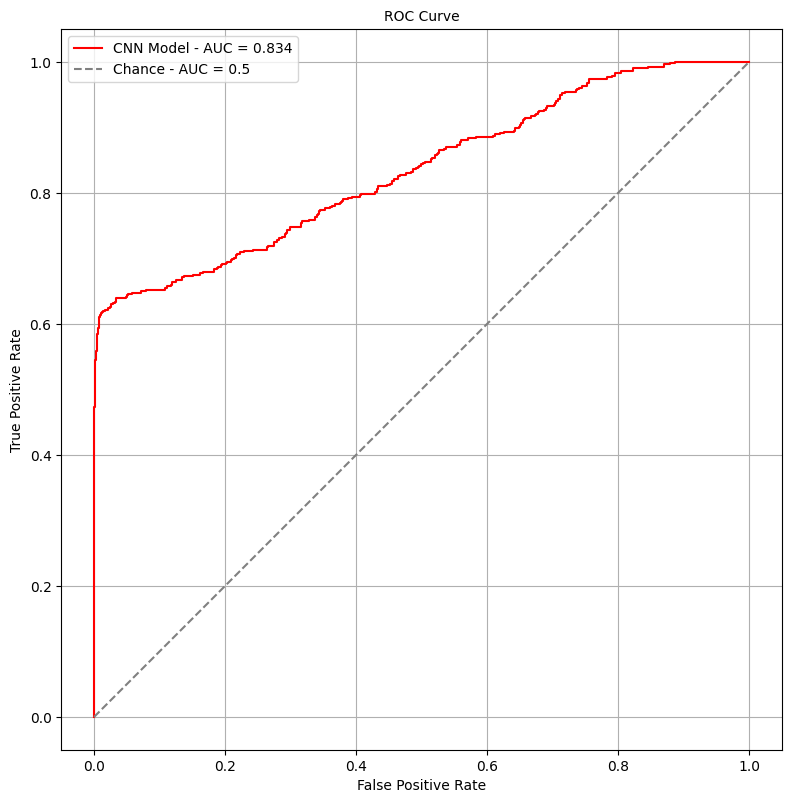

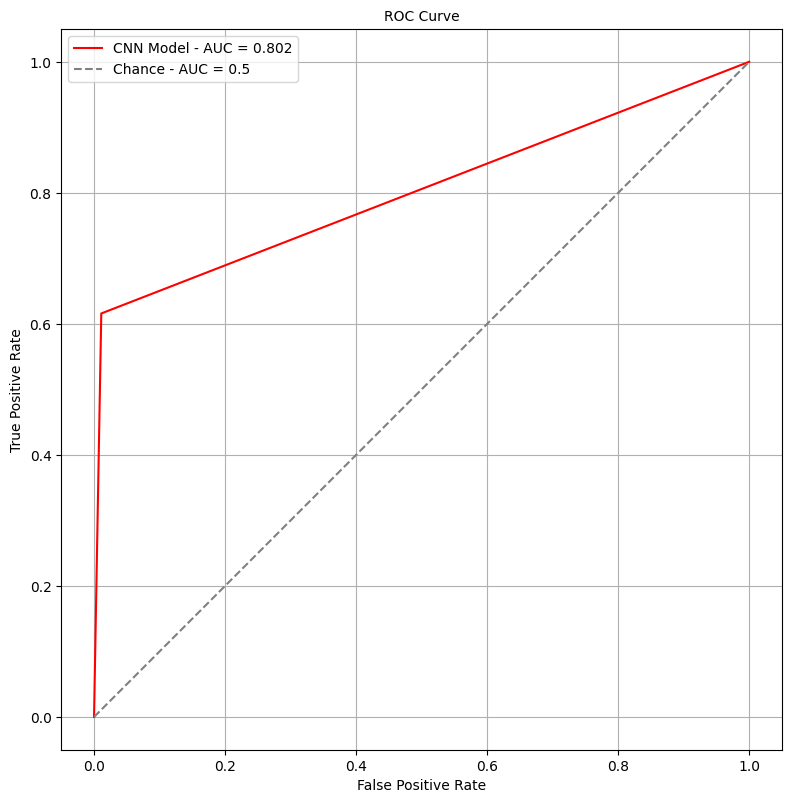

In [17]:
# plot ROC
y_pred = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]
plot_roc(y,  cnn_y_hat_prob)
plot_roc(y, y_pred)

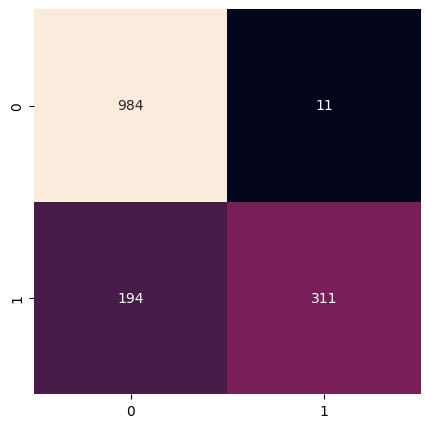

In [18]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y, y_pred), annot = True, cbar = False, fmt='.0f')
plt.show()